# INFO 2950 Final Project Phase II  
Mary Kolbas (mck86)  
Tammy Zhang (tz332)  


## Research Questions
*What have you noticed in exploring your data? What do you know about the processes that generated the data?
Discuss these ideas with your collaborators (if working with others), with friends in the
course, and with course staff. Do you need to gather any additional data? Slightly
different data?*

1. **How does the amount of snowfall impact the number of birds that are reported at NY feeders? Does this vary based on the species of bird?**
- We want to explore if this data can tell us something about bird behavior, difficulties finding food in certain conditions, and if there are differences amongst different species of bird. From our data exploration, we can see that some birds increase in sighting as snow increases, while some do not appear impacted. We would like to investigate how observed group size differs among species and across different snow conditions. We want to dive deeper into why this might be the case, as well as incorporate other factors that might confound with snowfall. 

2. **What can the changes in different species of bird sighting over time tell us? Can these patterns and peaks be explained by bird behavior and migration patterns or are they explained by other factors, such as human interference? Are these at-risk populations, or is this fluctuation expected?**
- From our data exploration, when looking at the top 25 most popular birds (based on total sighting), some birds follow a trend of decreasing sighting while others have less clear patterns of peaks or seasonality. We want to explore whether these patterns can be explained by bird behavior (such as migration patterns and seasonality) or whether there are other impacts, such as human interference, at play. This is especially interesting in cases where sightings have unexplained peaks. We have access to data about where each sighting took place, including whether the area is considered a dense/urban area and presence of many different factors, such as what plantlife or other animals may be present. 

3. **What factors about the environment and time affect how many and what species of birds are sighted? Can we build a model to predict how many and what species of birds are expected based on the location/environment features or the time of day?**

## Data Cleaning (Appendix, Draft)
Our raw file comes from the [Project Feeder Watch](https://feederwatch.org/explore/raw-dataset-requests/) 2021 checklist data and site description data. This file is extremely large and has sighting from about November 2020 to April 2021. 

We decided to focus our research on only sighting in New York State, which is still a rather large subset of the data. As of right now, we have decided to drop `latitude` and `longitude`. We also dropped irrelevant columns, such as `ENTRY_TECHNIQUE` (a variable indicating method of site localization), `PROJ_PERIOD_ID` (calendar year of end of FeederWatch season), `sub_id` and `obs_id` (indentifiers for checklist or species respectively), `effort_hrs_atleast` (survey time), and `DATA_ENTRY_METHOD` (web/mobile/paper).

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [11]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [2]:
# reading in raw provided data
csv = pd.read_csv("PFW_2021_public.csv")

In [3]:
# making dataframe
df = pd.DataFrame(csv)

In [4]:
# dropping irrelevant columns
df.drop(['latitude', 'longitude', 'entry_technique', 'PROJ_PERIOD_ID', 'reviewed', 'sub_id', 'obs_id',
        'effort_hrs_atleast', 'Data_Entry_Method'], axis= 1, inplace= True)

In [5]:
# dropping observations outside of NY
df = df[df['subnational1_code'] == "US-NY"]

# dropping observations that are not valid
df = df[df['valid'] == 1]

In [6]:
df.head()

,loc_id,subnational1_code,Month,Day,Year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast
9808,L6731705,US-NY,11,14,2020,blujay,1,1,1,1,1,1,0.0
9809,L6731705,US-NY,11,14,2020,norcar,1,1,1,1,1,1,0.0
9810,L6731705,US-NY,11,14,2020,dowwoo,1,1,1,1,1,1,0.0
9811,L6731705,US-NY,11,14,2020,tuftit,2,1,1,1,1,1,0.0
9812,L6731705,US-NY,11,14,2020,bkcchi,2,1,1,1,1,1,0.0


We also created new dataframes to only specify the top 25 species for our data exploration.

In `species_limited_df` we have created bins (`snow_category`) to categorize the snowfall for all sightings where snow depth is not null.

The `species_limited_time` dataframe is a manipulated version of `species_limited_df` with a datetime object, allowing for time series calculations and comparisons.

The `df_timeofday` dataframe narrows the data down to only entries where one of the four sighting periods of the two-day observation period occur. In otherwords, only the entries such that `day1_am` + `day1_pm` + `day2_am` + `day2_pm` = 1, and also limits to the top 25 species. This allows us to plot differences in observation counts based on time of day (morning vs afternoon) in our exploratory section. 

In [7]:
# making a list of the 25 most frequently observed species
frequent_species = df['species_code'].value_counts()[:25].index

# creating new dataframe limited to just the most frequent species observations
species_limited_df = df[df['species_code'].isin(frequent_species)]

# dropping rows where snow depth was null
species_limited_df = species_limited_df.dropna(subset=['snow_dep_atleast'])

# creating new category with string corresponding to each value in snow depth (for binning in the line plots)
species_limited_df['snow_category'] = 'No Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 0.001, 'snow_category'] = '< 5 cm'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 5.000, 'snow_category'] = '5 to 15 cm'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 15.001, 'snow_category'] = '> 15 cm'

species_limited_df.head()

,loc_id,subnational1_code,Month,Day,Year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast,snow_category
9808,L6731705,US-NY,11,14,2020,blujay,1,1,1,1,1,1,0.0,No Snow
9809,L6731705,US-NY,11,14,2020,norcar,1,1,1,1,1,1,0.0,No Snow
9810,L6731705,US-NY,11,14,2020,dowwoo,1,1,1,1,1,1,0.0,No Snow
9811,L6731705,US-NY,11,14,2020,tuftit,2,1,1,1,1,1,0.0,No Snow
9812,L6731705,US-NY,11,14,2020,bkcchi,2,1,1,1,1,1,0.0,No Snow


In [8]:
species_limited_time = species_limited_df

# create a column that puts month, date, year in one string
species_limited_time['datestring'] = species_limited_time['Month'].astype(str) + "/" + species_limited_time['Day'].astype(str) + "/" + species_limited_time['Year'].astype(str)

#turn datestring into datetime and drop datestring
species_limited_time['date_time'] = pd.to_datetime(species_limited_time['datestring'], format='%m/%d/%Y')
species_limited_time.drop(columns="datestring")

#grouped by date_time (datetime object)
species_limited_time = species_limited_time.groupby(["species_code", "date_time"]).mean()[['how_many','snow_dep_atleast']]
species_limited_time.head()

how_many  snow_dep_atleast
species_code date_time                             
amecro       2020-11-14  3.613333          0.000013
             2020-11-15  2.916667          0.000083
             2020-11-16  6.555556          0.000111
             2020-11-17  2.400000          0.667000
             2020-11-18  3.555556          0.000667

In [9]:
#duplicating df
df_timeofday = df

#only using entries with unique time sightings (they only recorded sightings at one of the 4 time periods as opposed
#to multiple sighings aggregated)
df_timeofday = df_timeofday[df_timeofday['day1_am'] + df_timeofday['day1_pm'] + df_timeofday['day2_am'] + df_timeofday['day2_pm'] == 1]

# creating new category with string corresponding to unique sighting day1_am, day1_pm, day2_am, day2_pm
df_timeofday['unique_time'] = 'day1_am'
df_timeofday.loc[df_timeofday['day1_pm'] == 1, 'unique_time'] = 'day1_pm'
df_timeofday.loc[df_timeofday['day2_am'] == 1, 'unique_time'] = 'day2_am'
df_timeofday.loc[df_timeofday['day2_pm'] == 1, 'unique_time'] = 'day2_pm'

#limit to only top 25 species 
df_timeofday_specieslimited = df_timeofday[df_timeofday['species_code'].isin(frequent_species)]


C:\Users\mkolb\AppData\Local\Temp\ipykernel_18504\2953367980.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeofday['unique_time'] = 'day1_am'


We also created a joined dataframe `join_df` that combines `species_limited_df` and `sites_df` using an `INNER JOIN` on `loc_id`, which provides us with information about the environment in which the observation entry took place. By doing this, we lose about half of our `species_limited_df` data entries because their location is not described in `sites_df`. 

In [12]:
# reading in raw provided data
csv_sites = pd.read_csv("PFW_count_site_data_public_2021.csv")

#creating dataframe
sites_df = pd.DataFrame(csv_sites)

#join species_limited_df (sightings of top 25 species) with sites_df (location details)
%sql join_df << SELECT species_limited_df.loc_id, subnational1_code, species_code, how_many, snow_dep_atleast, snow_category,  date_time, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, evgr_trees_atleast, evgr_shrbs_atleast, dcid_trees_atleast, dcid_shrbs_atleast, fru_trees_atleast, cacti_atleast, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, fed_yr_round, fed_in_jan, fed_in_feb, fed_in_mar, fed_in_apr, fed_in_may, fed_in_jun, fed_in_jul, fed_in_aug, fed_in_sep, fed_in_oct, fed_in_nov, fed_in_dec, numfeeders_suet, numfeeders_ground, numfeeders_hanging, numfeeders_platfrm, numfeeders_humming, numfeeders_water, numfeeders_thistle, numfeeders_fruit, numfeeders_hopper, numfeeders_tube, numfeeders_other, population_atleast, count_area_size_sq_m_atleast FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;

Returning data to local variable join_df


In [14]:
join_df

,loc_id,subnational1_code,species_code,how_many,snow_dep_atleast,snow_category,date_time,proj_period_id,yard_type_pavement,yard_type_garden,...,numfeeders_platfrm,numfeeders_humming,numfeeders_water,numfeeders_thistle,numfeeders_fruit,numfeeders_hopper,numfeeders_tube,numfeeders_other,population_atleast,count_area_size_sq_m_atleast
0,L10011987,US-NY,amegfi,2,0.0,No Snow,2021-04-24,PFW_2021,0.0,0.0,...,4.0,0.0,NaN,NaN,0.0,0.0,3.0,0.0,5001.0,375.01
1,L10011987,US-NY,amegfi,2,0.0,No Snow,2021-04-24,PFW_2020,0.0,0.0,...,4.0,0.0,NaN,NaN,0.0,0.0,3.0,0.0,5001.0,375.01
2,L10012113,US-NY,dowwoo,2,5.0,5 to 15 cm,2021-01-30,PFW_2020,0.0,0.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,5001.0,1.01
3,L10049605,US-NY,moudov,2,0.0,No Snow,2021-04-29,PFW_2021,0.0,0.0,...,1.0,0.0,NaN,NaN,0.0,0.0,5.0,0.0,25001.0,1.01
4,L10049605,US-NY,moudov,2,0.0,No Snow,2021-04-29,PFW_2020,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,4.0,0.0,25001.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116405,L99209,US-NY,norcar,2,0.0,No Snow,2020-11-21,PFW_2003,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,375.01
1116406,L99209,US-NY,norcar,2,0.0,No Snow,2020-11-21,PFW_2004,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,375.01
1116407,L99209,US-NY,norcar,2,0.0,No Snow,2020-11-21,PFW_2005,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1116408,L99209,US-NY,norcar,2,0.0,No Snow,2020-11-21,PFW_2006,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,1.0,375.01


## Data Description
- What are the observations (rows) and the attributes (columns)? 
- Why was this dataset created?
- Who funded the creation of the dataset?
- What processes might have influenced what data was observed and recorded and what was not?
- What preprocessing was done, and how did the data come to be in the form that you are using?
- If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
- Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box).

Our data in `df` comprises of observations (rows) of bird sightings in NY state between November 2020 and April 2021. It has attributes (columns) of the following: 
- `loc_id`: Unique identifier for each survey site
- `subnational1_code`: Country abbreviation and State or Province abbreviation of each survey site. 
- `Month`: Month of 1st day of two-day sighting
- `Day`: Month of 1st day of two-day sighting
- `Year`: Year of 1st day of two-day sighting
- `species_code`: Bird species observed, stored as 6-letter species codes
- `how_many`: Maximum number of individuals seen at one time during observation period
- `valid`: Validity of each observation based on flagging system
- `day1_am`: binary indicating if observer watched during morning of count Day 1
- `day1_pm`: binary indicating if observer watched during afternoon of count Day 1
- `day2_am`: binary indicating if observer watched during morning of count Day 2
- `day2_pm`: binary indicating if observer watched during afternoon of count Day 2
- `snow_dep_atleast`: Participant estimate of minimum snow depth


In our case, we have constrained our data to only look at entries from NY state (`subnational1_code` = "US-NY") and are valid (`valid` = 1). 

In [26]:
df.head()

,loc_id,subnational1_code,Month,Day,Year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast
9808,L6731705,US-NY,11,14,2020,blujay,1,1,1,1,1,1,0.0
9809,L6731705,US-NY,11,14,2020,norcar,1,1,1,1,1,1,0.0
9810,L6731705,US-NY,11,14,2020,dowwoo,1,1,1,1,1,1,0.0
9811,L6731705,US-NY,11,14,2020,tuftit,2,1,1,1,1,1,0.0
9812,L6731705,US-NY,11,14,2020,bkcchi,2,1,1,1,1,1,0.0


Our data in `join_df` comprises of observations (rows) of bird sightings in NY state between November 2020 and April 2021 from `df`, with additional columns from `sites_df`, which has attributes regarding location/environment details based on a unique location id. This dataframe has new additional attributes (columns) of the following: 

# sites_df fields I haven't included below yet:
, , , , , ,, , , , , , , ,, , , , , , , , , , , , , , , , , , , , , , fed_in_jan, fed_in_feb, fed_in_mar, fed_in_apr, fed_in_may, fed_in_jun, fed_in_jul, fed_in_aug, fed_in_sep, fed_in_oct, fed_in_nov, fed_in_dec, numfeeders_suet, numfeeders_ground, numfeeders_hanging, numfeeders_platfrm, numfeeders_humming, numfeeders_water, numfeeders_thistle, numfeeders_fruit, numfeeders_hopper, numfeeders_tube, numfeeders_other, population_atleast, count_area_size_sq_m_atleast

- `proj_period_id`: Calendar year of end of FeederWatch season
- `yard_type_pavement`: binary variable whether location is pavement (no vegetation)
- `yard_type_garden`: binary variable whether location is a garden/courtyard 
- `yard_type_landsca`: binary variable whether location is a landscaped yard
- `yard_type_woods`: binary variable whether location is a natural vegetation
- `yard_type_desert`: binary variable whether location is a natural or landscaped desert
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_evgr_woods`: binary variable whether location is within 0.5mi from evergreen woods
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_mixed_woods`: binary variable whether location is within 0.5mi from mixed deciduous-evergreen woods
- `hab_orchard`: binary variable whether location is within 0.5mi from an orchard
- `hab_park`: binary variable whether location is within 0.5mi from a park
- `hab_water_fresh`: binary variable whether location is within 0.5mi from fresh water
- `hab_water_salt`: binary variable whether location is within 0.5mi from salt water
- `hab_residential`: binary variable whether location is within 0.5mi from a residential area
- `hab_industrial`: binary variable whether location is within 0.5mi from an industrial or commercial area
- `hab_agricultural`: binary variable whether location is within 0.5mi from an agricultural fields
- `hab_desert_scrub`: binary variable whether location is within 0.5mi from a desert or scrub
- `hab_young_woods`: binary variable whether location is within 0.5mi from an secondary growth woods
- `hab_swamp`: binary variable whether location is within 0.5mi from a swamp (wooded)
- `hab_marsh`: binary variable whether location is within 0.5mi from a marsh
- `evgr_trees_atleast`: Minimum number of evergreen trees within the count area
- `evgr_shrbs_atleast`: Minimum number of evergreen shrubs within the count area
- `dcid_trees_atleast`: Minimum number of deciduous trees within the count area
- `dcid_shrbs_atleast`: Minimum number of deciduous shrubs within the count area
- `fru_trees_atleast`: Minimum number of fruit trees within the count area
- `cacti_atleast`: Minimum number of cacti within the count area
- `brsh_piles_atleast`: Minimum number of brush piles within the count area
- `water_srcs_atleast`: Minimum number of water sources within the count area
- `bird_baths_atleast`: Minimum number of bird baths within the count area
- `nearby_feeders`: binary variable whether other feeders (aside from those maintained by participant) within 90m of the count site
- `squirrels`: binary variable whether squirrels take food from the feeders at least 3 times a week
- `cats`: binary variable whether cats are active within 30m of the feeder for at least 30 min 3 times a week
- `dogs`: binary variable whether dogs are active within 30m of the feeder for at least 30 min 3 times a week
- `humans`: binary variable whether humans are active within 30m of the feeder for at least 30 min 3 times a week
- `housing_density`: Participant-defined description of the housing density of the neighborhood, where 1 = "rural", 2 = "rural/suburban", 3 = "suburban", 4 = "urban"
- `fed_yr_round`: binary variable whether participant provides food year-round


# not done with this but I think we should cut some irrelevant ones :')


In [27]:
join_df.head()

,loc_id,subnational1_code,species_code,how_many,snow_dep_atleast,snow_category,date_time,proj_period_id,yard_type_pavement,yard_type_garden,...,numfeeders_platfrm,numfeeders_humming,numfeeders_water,numfeeders_thistle,numfeeders_fruit,numfeeders_hopper,numfeeders_tube,numfeeders_other,population_atleast,count_area_size_sq_m_atleast
0,L10011987,US-NY,amegfi,2,0.0,No Snow,2021-04-24,PFW_2021,0.0,0.0,...,4.0,0.0,NaN,NaN,0.0,0.0,3.0,0.0,5001.0,375.01
1,L10011987,US-NY,amegfi,2,0.0,No Snow,2021-04-24,PFW_2020,0.0,0.0,...,4.0,0.0,NaN,NaN,0.0,0.0,3.0,0.0,5001.0,375.01
2,L10012113,US-NY,dowwoo,2,5.0,5 to 15 cm,2021-01-30,PFW_2020,0.0,0.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,5001.0,1.01
3,L10049605,US-NY,moudov,2,0.0,No Snow,2021-04-29,PFW_2021,0.0,0.0,...,1.0,0.0,NaN,NaN,0.0,0.0,5.0,0.0,25001.0,1.01
4,L10049605,US-NY,moudov,2,0.0,No Snow,2021-04-29,PFW_2020,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,4.0,0.0,25001.0,1.01


This dataset was created by Project FeederWatch for researchers seeking to conduct formal analyses, but also to have this data be freely accessible to students, journalists, and the general public. The data is collected by contributors and participants. It is created and supported by Cornell Lab and Birds Canada. Since 2016, Project FeederWatch has been sponsored by Wild Bird Unlimited. 

Because this is community-currated data, there are many processes that may have influenced what data was observed/recorded and what was not, including mislogging information. This dataset involved a validity checker that flags odd sightings and has them checked by a reviewer. The data we will be using for this project drops invalid observations. FeederWatch also notes there may be mislogged locations in `subnational1_code` represented "XX" locations, which we dropped when choosing to only look at NY state data. 

Because this is community-currated data, there is also volunteer bias in observations, as certain locations or species may be more common in the dataset due to active and dedicated users. However, many users are also very knowledgeable about birds, and therefore can provide a lot of information and identification resources. 

Preprocessing was done to change the very large dataset into a smaller, more manageable one with relevant columns. We filtered the data, dropped irrelevant columns, and added columns to bin data or aid in time series analysis. Details on the Data Cleaning process can be found in the appendix. 

Our raw datasource can be found [here](https://cornell.box.com/s/wzdfg3lotvqr6wc5ik680jzit8fu3t7s) via Cornell Box, or on the [FeederWatch Website](https://feederwatch.org/explore/raw-dataset-requests/).

## Data Limitations

There are some notable limitations with our dataset - as FeederWatch notes on their website, the sheer scale of the data collected and the nature of citizen science involving a large number of participants taking unverifiable observations in varying circumstances mean that the data inherently will have imperfections. For example, some species may appear highly similar to each other, which may cause increased rates of misidentification for those species. When proceeding with further analysis, this effect can be limited somewhat by grouping together similar species into general families. FeederWatch also notes that it is likely for meaningful biological patterns to still emerge from the data despite the possibility of erroneous entries.

A significant limitation of the data is described by FeederWatch as follows: "a recorded observation is a function of both the biological event (number of species actually present) and the observation process (probability that an individual, when present, will be observed)". Without using formal estimation of detection probabilities, it cannot be said that higher numbers of observations for a species necessarily indicate that the species is actually present at greater frequencies - we can only make conclusions about observations, not definitively the state of the biological system. 

For example, we cannot say with complete confidence that a species is more frequent in a certain month - only that it is more frequently observed in that month. While a subtle nuance, this is important to consider. For example, it is possible there are species which are very frequent feeder visitors, but are rarely observed due to visiting at times people tend not to be observing, are quick and difficult to identify, etc.

Without taking these limitations into consideration, there is a risk of erroneously representing the data and misleading people about the state of avian biodiversity.

## Exploratory Data Analysis

### Exploring effect of snow levels on sightings by species

In [ ]:
# creating plotting function
def plot_by_species(df):
    # grouping by species and snow, averaging counts for each species per snow category
    average = df.groupby(by=['species_code', 'snow_category']).mean()
    average = average.reindex(index = ['No Snow','< 5 cm','5 to 15 cm', '> 15 cm'], level = 1)
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    ax = sns.lineplot(data = average, x = average.index.get_level_values(1).to_list(), y = average['how_many'], hue='species_code', marker='o').set(title="Avian Species at Feeders with Different Snow Levels")
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    return ax

In [ ]:
plot_by_species(species_limited_df)

### Exploring sightings over time based on species

After creating a new datetime object in the `date_time` column, we can plot sightings over time and see trends. By plotting seperate graphs for each of the top 25 species, we can see different trends over time. 

For example, `bkcchi`, `blujay`, and `tuftit` appear to decrease during the time period from November to April. `norcar` seems to peak in February/March, and `moudov` starts to disappear around March. These are all unique trends such that we can't conclude all 25 of these species follow the same pattern. 

This means we can explore further how species plays a part on bird sightings. Further contextual understanding can be done about whether this is a trend based on migration or behavioral patterns, or whether such decreases may be alarming or unusual. If necessary, we could even incorportate additional Feeder Watch data from previous years.

In [ ]:
#creating plotting function to plot each species in df over time
def plot_by_year(df):
    g = sns.lineplot(x="date_time", y="how_many", data=df)
    ax = plt.gca()
    ax.set_title(str(df.index[0][0]))
    plt.show()
species_limited_time.groupby("species_code").apply(plot_by_year)

### Exploring affect of housing density on sightings by species

Each entry in the dataset aggregated from a two-day watch period. The dataset breaks this down into `day1_am`, `day1_pm`, `day2_am` and `day2_pm`. Unfortunately, most entries comprise of sightings from multiple of these 4 time periods. Although this shouldn't be a problem in modeling analysis, in order to visually explore these trends, we had to consider only entries where the entire sighting was only during one of these four periods. 

After narrowing the dataset, we created a new column `unique_time` containing the string of the time period, and used these as categories to plot them for each of the top 25 species. 

[Text(0.5, 1.0, 'Avian Species at Feeders at Different Sighting Times')]

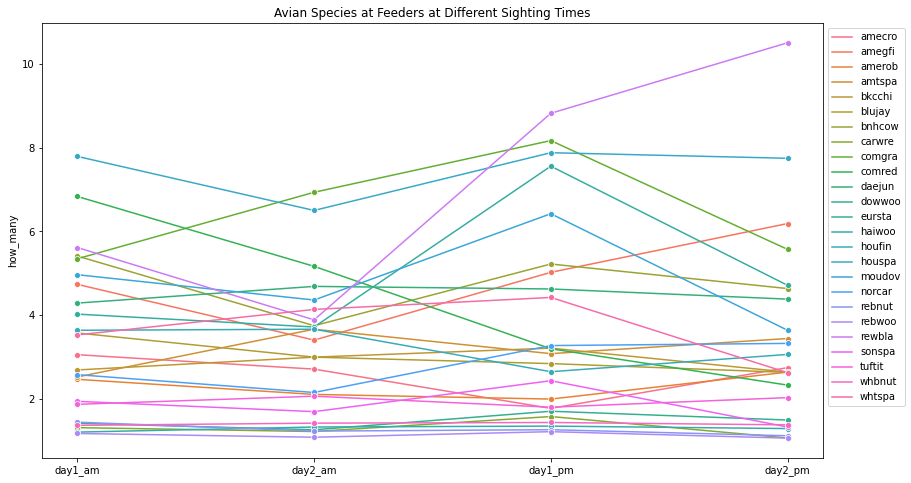

In [19]:
# creating plotting function
def plot_uniquetime(df):
    # grouping by species and unique_time, averaging counts for each species per time category
    average = df.groupby(by=['species_code', 'unique_time']).mean()
    average = average.reindex(index = ['day1_am','day2_am', 'day1_pm', 'day2_pm'], level = 1)
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    ax = sns.lineplot(data = average, x = average.index.get_level_values(1).to_list(), y = average['how_many'], hue='species_code', marker='o').set(title="Avian Species at Feeders at Different Sighting Times")
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    return ax

#plotting 
plot_uniquetime(df_timeofday_specieslimited)

### Exploring effect of housing density by species 

In [20]:
join_df[['loc_id', 'species_code', 'how_many', 'housing_density']].groupby(['housing_density','species_code']).mean()

how_many
housing_density species_code          
1.0             amecro        2.738810
                amegfi        7.179228
                amerob        3.342965
                amtspa        3.349681
                bkcchi        4.461740
...                                ...
4.0             rewbla        3.701897
                sonspa        2.190128
                tuftit        1.828748
                whbnut        1.331871
                whtspa        2.524496

[100 rows x 1 columns]

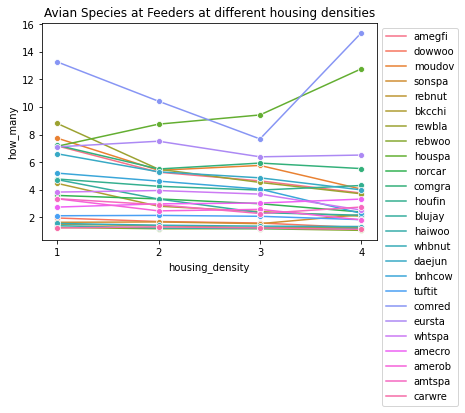

In [24]:
def plot_housing_density(df):
    g = sns.lineplot(x="housing_density", y="how_many", data=df, hue='species_code',  marker='o', ci=None)
    ax = plt.gca()
    ax.set_title("Avian Species at Feeders at different housing densities")
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    ax.set_xticks([1,2,3,4])
    plt.show()
plot_housing_density(join_df_specieslimited)

## Questions for reviewers